# Préparation des données 

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Données

In [ ]:
import pandas as p
import numpy as np

df = p.read_csv('./ensae_competition_train.txt', header=[0,1], sep="\t", index_col=0)

#### Gender dummies
df['X2'] = df['X2'].applymap(str)
gender_dummies = p.get_dummies(df['X2'] )
### education dummies
df['X3'] = df['X3'].applymap(str)
educ_dummies = p.get_dummies(df['X3'] )
#### marriage dummies
df['X4'] = df['X4'].applymap(str)
mariage_dummies = p.get_dummies(df['X4'] )
### On va aussi supprimer les multi index de la table
df.columns = df.columns.droplevel(0)
#### on aggrège ensuite les 3 tables ensemble
data = df.join(gender_dummies).join(educ_dummies).join(mariage_dummies)

data.rename(columns = {'default payment next month' : "Y"}, inplace = True)

data = data.drop(['SEX','EDUCATION','MARRIAGE'],1)

data_resample = p.concat([data[data['Y']==1], data[data['Y']==0].sample(len(data[data['Y']==1]))])

data.head(n=2)

ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,180000,47,0,0,0,0,0,0,179253,95170,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,110000,35,0,0,0,0,0,0,6137,7040,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
Y = data['Y']
Y = data_resample['Y']

X = data.drop('Y', 1)
#X = data[["SEX_1", "AGE", "MARRIAGE_0", 'PAY_0']]
X = data_resample.drop('Y',1)

X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3'],
      dtype='object', name='ID')

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

## Choix du Classifieur

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Perceptron

#type_classifier = LogisticRegression
#type_classifier = svm.SVC
type_classifier = GradientBoostingClassifier
#type_classifier = RandomForestClassifier
#type_classifier = Perceptron

clf = type_classifier()
#clf = SGDClassifier(loss="hinge", penalty="l2")

clf = clf.fit(X_train, Y_train.ravel())

In [ ]:
# Matrice de confusion

In [ ]:
%matplotlib inline

[[2639 1049]
 [ 677 2308]]
[[1272  592]
 [ 392 1031]]


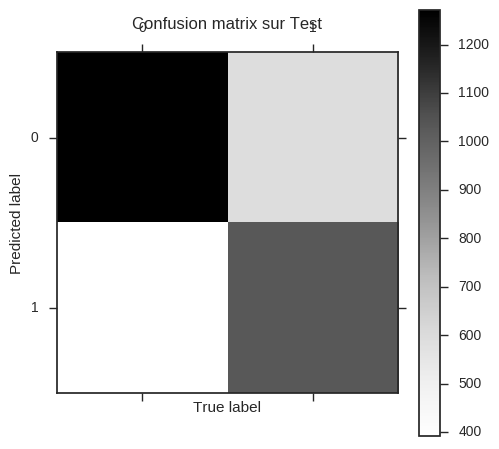

In [ ]:
from sklearn.metrics import confusion_matrix
for x,y in [ (X_train, Y_train), (X_test, Y_test) ]:
    yp  = clf.predict(x)
    cm = confusion_matrix(y.ravel(), yp.ravel())
    print(cm.transpose())
    
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
plt.matshow(cm.transpose())
plt.title('Confusion matrix sur Test')
plt.colorbar()
plt.ylabel('Predicted label')
plt.xlabel('True label')

In [ ]:
(cm.transpose()[0,0]+cm.transpose()[1,1])/ (cm[0].sum()+cm[1].sum())

0.70063888043808942

## Calcul du critère AUC 

In [ ]:
from sklearn.metrics import roc_curve, auc
probas = clf.predict_proba(X_test)

probas

array([[ 0.41760586,  0.58239414],
       [ 0.68713032,  0.31286968],
       [ 0.5714975 ,  0.4285025 ],
       ..., 
       [ 0.31742502,  0.68257498],
       [ 0.10803069,  0.89196931],
       [ 0.18440702,  0.81559298]])

In [ ]:
rep = [ ]
yt = Y_test.ravel()
for i in range(probas.shape[0]):
    p0,p1 = probas[i,:]
    exp = yt[i]
    if p0 > p1 :
        if exp == 0 :
            # bonne réponse, true positive (tp)
            rep.append ( (1, p0) )
        else :
            # mauvaise réponse, false positive (fp)
            rep.append( (0, p0) )
    else :
        if exp == 0 :
            # mauvaise réponse, false negative (fn)
            rep.append ( (0, p1) )
        else :
            # bonne réponse, true negative (tn)
            rep.append( (1, p1) )
mat_rep = np.array(rep)
print("AUC : Taux de bonnes réponses" , sum(mat_rep[:,0]) / len(mat_rep[:,0]))

AUC : Taux de bonnes réponses 0.700638880438


Tous les critères sont détaillés [là](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Attention au sens de la matrice de confusion, selon les articles, cela change.

## Courbe ROC

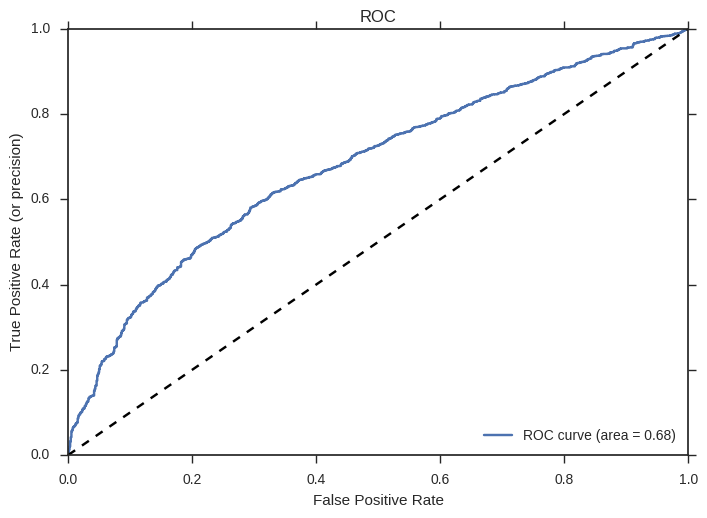

In [ ]:
fpr, tpr, thresholds = roc_curve(mat_rep[:,0], mat_rep[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (or precision)')
plt.title('ROC')
plt.legend(loc="lower right")

En haut à droite, TPR et FPR valent 1 (il suffit de prédire toujours positif = pas de défaut = Y_hat=0), en bas à gauche, TPR et FPR valent 0 parce qu'il suffit de toujours prédire la situation négative (ou le défaut, Y_hat = 1). 

Une autre métrique souvent suivie consiste à comparer Precision (= TPR) et Recall. C'est un peu le même arbitrage. Cela devrait vous rappeler celui entre risque de première espèce et puissance d'un test.

## Précision-Recall, Score F1 

In [ ]:
tp=0
fp=0
fn=0
tn=0
for i in range(len(probas[:,0])):
    if (probas[i,0] >= 0.5 and yt[i] == 0):
        tp+=1
    elif (probas[i,0] >= 0.5 and yt[i] == 1):
        fp+=1
    elif (probas[i,0] <= 0.5 and yt[i] == 0):
        fn+=1
    else:
        tn+=1
print("On retrouve la matrice de confusion :\n", "TP : ", tp, "FP : ", fp, "\n", 
      " FN : ", fn, "TN : ", tn)
print("Precision : TP / (TP + FP) = ", tp/(tp+fp))
print("Recall : TP / (TP + FN) = ", tp/(tp+fn))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("F1 Score : T2 * P * R / (P + R) = ", 2 * precision * recall / (precision + recall) )
print("False Positive rate : FP / (FP + FN) = ", fp/(fp+tn))

On retrouve la matrice de confusion :
 TP :  1272 FP :  592 
  FN :  392 TN :  1031
Precision : TP / (TP + FP) =  0.6824034334763949
Recall : TP / (TP + FN) =  0.7644230769230769
F1 Score : T2 * P * R / (P + R) =  0.7210884353741496
False Positive rate : FP / (FP + FN) =  0.3647566235366605


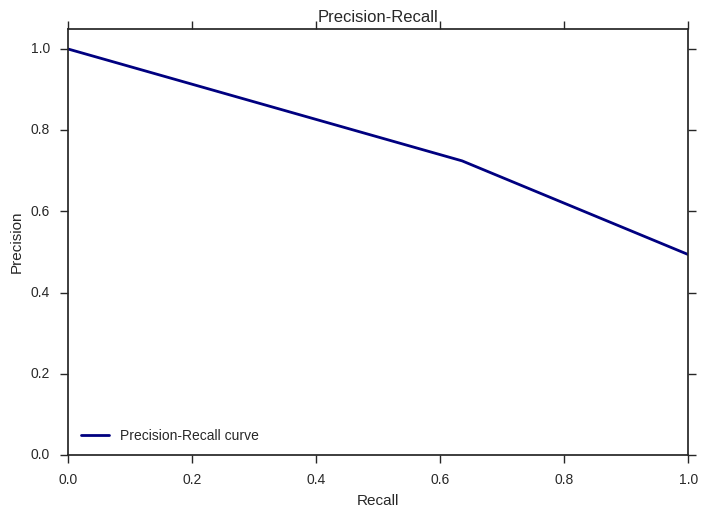

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(Y_test.ravel(), yp.ravel())

lw = 2

plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")